# Actividad 4:
# Evolución de Modelos Predictivos: Ajuste de Hiperparámetros con Algoritmos Genéticos

## Objetivo
Aplicar un Algoritmo Genético para ajustar los hiperparámetros de un modelo de clasificación binaria (RandomForestClassifier), utilizando el conjunto de datos Breast Cancer Wisconsin de Scikit-learn. Se busca evaluar la efectividad del enfoque genético frente a métodos tradicionales de búsqueda.

**Dataset utilizado:**  
Cáncer de mama de Scikit-learn

---

> **Advertencia: debido a que los resultados entre ejecuciones presentaban pequeñas diferencias, se decidió dejar la celda con las salidas para que las conclusiones y reflexiones tengan sentido con lo que se visualiza. Por esto mismo, no solo se muestran las comparaciones de F1-Score y otras métricas, si no que se muestra un gap de la diferencia entre desempeño en los datos de entrenamiento y prueba, para que, si el código es ejecutado nuevamente y el F1-Score fuera levemente menor que el del modelo base, se pueda observar que incluso con eso el gap difference muestra que el modelo optimizado con AG presenta mucha mas estabilidad frente a datos nuevos. **

---

### Estructura del Notebook:
1. Metodología.
2. Configuración inicial del notebook.
3. Definicion de funciones.
4. Uso de funciones y resultados.
5. Análisis de los resultados y reflexiones finales.

---

## 1. Metodología

---

### Flujo de trabajo
1. **Carga de datos:**
   - Escalado de características con `StandardScaler`.
   - División de datos en entrenamiento y prueba (70% / 30%) con estratificación de clases.

2. **Algoritmo genético:**
   - **Codificación genética:** Vector `[n_estimators, max_depth, min_samples_split]`.
   - **Población inicial:** 10 individuos generados aleatoriamente.
   - **Función de aptitud:** Promedio del F1 Score en validación cruzada 5-fold.
   - **Operadores genéticos:**
      - Cruce: Two-point crossover (`cxTwoPoint`) con probabilidad 0.7.
      - Mutación: `mutUniformInt` con `indpb=0.3`.
      - Selección: Torneo (tamaño 3).
   - **Número de generaciones:** 15.
   - **Hall of Fame:** Conserva al mejor individuo.

3. **Evaluación de modelos:**
   - **Modelo base:** RandomForestClassifier con hiperparámetros por defecto.
   - **Modelo optimizado:** Entrenado con los mejores hiperparámetros encontrados por el AG.
   - **Métricas evaluadas (en train y test):**
      - Precisión (`precision`).
      - Recall.
      - F1 Score.
      - AUC (`roc_auc_score`).
   - **Extras:**
      - Tiempos de entrenamiento y predicción.
      - Importancia de variables.
      - Brecha de desempeño entre entrenamiento y prueba.

4. **Comparación y visualización:**
   - Tabla comparativa de métricas.
   - Gráfico de evolución del AG.
   - Comparación del tiempo total entre modelo base y modelo optimizado.
   - Gráfico de importancias de características.
   - Brecha de sobreajuste (gap train/test).

---

# 2. Configuración inicial del notebook
- Importación de librerias necesarias.
- Configuraciones necesarias para el correcto manejo de las salidas del código.
- Solución a un problema relacionado con DEAP usando try-except.

--- 

In [1]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, f1_score, 
                             precision_score, recall_score, 
                             roc_auc_score)
from deap import base, creator, tools, algorithms
import random
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Configuración visual y de entorno
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
pd.set_option('display.precision', 4)
pd.set_option('display.max_columns', None)

# En algunos entornos, DEAP no permite redefinir creators si ya han sido definidos.
# Esto lanza un error si se ejecuta más de una vez. Este bloque evita ese problema.
try:
    del creator.FitnessMax
    del creator.Individual
except Exception:
    pass

# 3. Definición de funciones

> **Nota:** Para mejor comprensión de las funciones y su utilidad, esta sección se divide en bloques, en donde cada uno responde a una parte diferente de la metodología de trabajo. 

---

**Bloque 1:** Carga y preprocesamiento de datos

- **`load_data()`** 
Carga el dataset de cáncer de mama, aplica escalado estándar y divide los datos en conjuntos de entrenamiento y prueba estratificados.

In [2]:
def load_and_preprocess_data():
    """
    Carga el dataset de cáncer de mama, aplica escalamiento estándar y divide en conjuntos
    de entrenamiento y prueba con estratificación.

    Returns:
        tuple: tupla que contiene los datos escalados divididos y los nombres de características.
    """
    datos = load_breast_cancer()
    x = datos.data
    y = datos.target
    escalador = StandardScaler()
    x_escalado = escalador.fit_transform(x)
    return train_test_split(x_escalado, y, test_size=0.3, random_state=42, stratify=y), datos.feature_names

**Bloque 2:** Algoritmo genético: definición y ejecución

- **`create_deap_toolbox()`** 
Define el espacio de búsqueda para los hiperparámetros, crea la población, la función de aptitud basada en validación cruzada con F1, y registra los operadores genéticos (cruce, mutación, selección).

- **`run_genetic_algorithm()`** 
Ejecuta el ciclo evolutivo del algoritmo genético durante un número definido de generaciones, conservando el mejor individuo y registrando estadísticas del proceso.

In [3]:
def create_deap_toolbox(x, y):
    """
    Crea el entorno del algoritmo genético usando DEAP con rangos de hiperparámetros ajustados 
    para evitar sobreajuste.

    Args:
        x (np.ndarray): datos de entrenamiento.
        y (np.ndarray): etiquetas de entrenamiento.

    Returns:
        Toolbox: objeto DEAP toolbox configurado.
    """
    # Definir rangos para los hiperparámetros que serán optimizados
    n_estimators = (50, 300)
    max_depth = (5, 30)
    min_samples_split = (2, 20)

    # Crear clases personalizadas para la función de fitness y para los individuos
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMax)

    # Inicializar toolbox que contendrá todos los operadores genéticos
    toolbox = base.Toolbox()
    
    # Registrar generadores aleatorios para cada hiperparámetro dentro de sus rangos
    toolbox.register("n_estimators", random.randint, *n_estimators)
    toolbox.register("max_depth", random.randint, *max_depth)
    toolbox.register("min_samples_split", random.randint, *min_samples_split)
    
    # Definir cómo se crea un individuo: un ciclo con un valor para cada hiperparámetro
    toolbox.register("individual", tools.initCycle, creator.Individual,
                     (toolbox.n_estimators, toolbox.max_depth, toolbox.min_samples_split), n=1)
    
    # Definir cómo se crea la población: una lista de individuos
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    # Función interna para evaluar el desempeño de un individuo (conjunto de hiperparámetros)
    def evaluar_rf(individuo):
        # Extraer hiperparámetros desde el individuo
        n_estimators, max_depth, min_samples_split = individuo
        
        # Crear el modelo Random Forest con esos hiperparámetros
        modelo = RandomForestClassifier(
            n_estimators=n_estimators,
            max_depth=max_depth,
            min_samples_split=min_samples_split,
            random_state=42,
            n_jobs=-1,
        )
        # Calcular el F1 Score promedio usando validación cruzada 5-fold
        puntajes = cross_val_score(modelo, x, y, cv=5, scoring='f1')
        
        # Devolver el valor medio como una tupla (requerido por DEAP)
        return (puntajes.mean(),)

    # Registrar la función de evaluación dentro del toolbox
    toolbox.register("evaluate", evaluar_rf)
    
    # Registrar el operador de cruce (two-point crossover)
    toolbox.register("mate", tools.cxTwoPoint)
    
    # Registrar el operador de mutación con mutUniformInt y probabilidad de mutación indpb=0.3
    toolbox.register("mutate", tools.mutUniformInt, low=[50, 3, 5], up=[200, 8, 20], indpb=0.3)
    
    # Registrar el operador de selección por torneo con tamaño 3
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    # Devolver el toolbox configurado listo para usarse en el AG
    return toolbox

def run_genetic_algorithm(toolbox, ngen=15, pop_size=10):
    """
    Ejecuta el algoritmo genético usando DEAP con parámetros definidos.

    Args:
        toolbox (Toolbox): configuración del entorno genético.
        ngen (int): número de generaciones.
        pop_size (int): tamaño de la población.

    Returns:
        tuple: población final, mejores individuos, registro de evolución y tiempo de ejecución.
    """
    # Registrar el tiempo de inicio para medir duración total del AG
    tiempo_inicio = time.time()
    
    # Crear la población inicial con el tamaño especificado
    poblacion = toolbox.population(n=pop_size)
    
    # Crear el Hall of Fame para almacenar el mejor individuo encontrado
    hof = tools.HallOfFame(1)
    
    # Crear objeto para recolectar estadísticas de aptitud durante la evolución
    estadisticas = tools.Statistics(lambda ind: ind.fitness.values)
    
    # Registrar estadísticas promedio, máximo y mínimo para cada generación
    estadisticas.register("avg", np.mean)
    estadisticas.register("max", np.max)
    estadisticas.register("min", np.min)
    
    # Crear registro para almacenar la evolución del proceso
    registro = tools.Logbook()
    
    # Ejecutar el algoritmo genético con parámetros:
    # cxpb=0.7: probabilidad de cruce
    # mutpb=0.3: probabilidad de mutación
    # ngen: número de generaciones
    # stats: estadísticas a registrar
    # halloffame: objeto para conservar el mejor individuo
    # verbose=False para evitar salida de texto durante ejecución
    poblacion, registro = algorithms.eaSimple(
        poblacion, toolbox, cxpb=0.7, mutpb=0.3, ngen=ngen,
        stats=estadisticas, halloffame=hof, verbose=False
    )
    
    # Calcular el tiempo total transcurrido en segundos
    tiempo_total = time.time() - tiempo_inicio
    
    # Devolver la población final, el Hall of Fame, el registro de evolución y el tiempo total
    return poblacion, hof, registro, tiempo_total

**Bloque 3:** Evaluación y métricas del modelo

- **`evaluate_model()`** 
Entrena un RandomForestClassifier con parámetros dados o por defecto, mide tiempos de entrenamiento y predicción, y calcula métricas clave (precision, recall, f1, auc) para train y test.

In [4]:
def evaluate_model(x_train, x_test, y_train, y_test, params=None):
    """
    Entrena un modelo Random Forest (base u optimizado), calcula métricas, tiempos y retorna todo.

    Args:
        x_train (np.ndarray): datos de entrenamiento.
        x_test (np.ndarray): datos de prueba.
        y_train (np.ndarray): etiquetas de entrenamiento.
        y_test (np.ndarray): etiquetas de prueba.
        params (dict): hiperparámetros del modelo.

    Returns:
        tuple: dataframe con reporte de clasificación, métricas train y test, modelo entrenado,
               tiempo de entrenamiento y tiempo de predicción.
    """
    # Crear el modelo RandomForestClassifier con hiperparámetros dados o por defecto
    if params:
        modelo = RandomForestClassifier(**params, random_state=42, n_jobs=-1)
    else:
        modelo = RandomForestClassifier(random_state=42, n_jobs=-1)
    
    # Medir tiempo de entrenamiento del modelo
    inicio_entreno = time.time()
    modelo.fit(x_train, y_train)
    tiempo_entreno = time.time() - inicio_entreno

    # Predecir sobre el conjunto de entrenamiento y prueba
    y_pred_train = modelo.predict(x_train)
    y_pred_test = modelo.predict(x_test)

    # Calcular métricas clave para el conjunto de entrenamiento (promedio ponderado)
    precision_train = precision_score(y_train, y_pred_train, average='weighted')
    recall_train = recall_score(y_train, y_pred_train, average='weighted')
    f1_train = f1_score(y_train, y_pred_train, average='weighted')
    auc_train = roc_auc_score(y_train, modelo.predict_proba(x_train)[:, 1])

    # Calcular métricas clave para el conjunto de prueba (promedio ponderado)
    precision_test = precision_score(y_test, y_pred_test, average='weighted')
    recall_test = recall_score(y_test, y_pred_test, average='weighted')
    f1_test = f1_score(y_test, y_pred_test, average='weighted')
    auc_test = roc_auc_score(y_test, modelo.predict_proba(x_test)[:, 1])

    # Medir tiempo de predicción en el conjunto de prueba
    inicio_pred = time.time()
    modelo.predict(x_test)
    tiempo_pred = time.time() - inicio_pred

    # Generar reporte de clasificación detallado en formato diccionario y luego DataFrame
    reporte = classification_report(y_test, y_pred_test, output_dict=True)
    df_reporte = pd.DataFrame(reporte).transpose()

    # Agrupar métricas en diccionarios para train y test
    metricas_train = {'precision': precision_train, 'recall': recall_train, 'f1': f1_train, 'auc': auc_train}
    metricas_test = {'precision': precision_test, 'recall': recall_test, 'f1': f1_test, 'auc': auc_test}

    # Devolver reporte, métricas, modelo entrenado y tiempos medidos
    return df_reporte, metricas_train, metricas_test, modelo, tiempo_entreno, tiempo_pred

**Bloque 4:** Visualización y análisis comparativo

- **`plot_combined_results()`** 
Muestra la evolución del AG y compara métricas principales entre modelo base y modelo optimizado en el conjunto de prueba.

- **`plot_feature_importance_and_gap()`** 
Visualiza la importancia relativa de las 10 principales variables y el gap entre desempeño en entrenamiento y prueba para ambos modelos.

- **`plot_total_time_comparison()`** 
Compara el tiempo total consumido por el modelo base y por el proceso completo optimizado con AG.

In [ ]:
def plot_combined_results(registro, metricas_test_base, metricas_test_opt):
    """
    Genera gráficos que muestran el progreso del algoritmo genético y
    la comparación de desempeño entre modelo base y optimizado.

    Args:
        registro (Logbook): historial del algoritmo genético.
        metricas_test_base (dict): métricas del modelo base en test.
        metricas_test_opt (dict): métricas del modelo optimizado en test.
    """
    # Crear figura y dos ejes para dos gráficos lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Extraer datos de generaciones, máximos, encontrar generación con mejor F1
    generaciones = registro.select("gen")
    maximos = registro.select("max")
    mejor_gen = np.argmax(maximos)
    mejor_f1 = maximos[mejor_gen]
    
    # Gráfico 1: Área entre mínimo y máximo + líneas de máximo y promedio F1 por generación
    ax1.fill_between(generaciones, registro.select("min"), maximos, color='skyblue', alpha=0.3)
    ax1.plot(generaciones, maximos, 'g-', linewidth=2, label="F1 Máximo")
    ax1.plot(generaciones, registro.select("avg"), 'b-', linewidth=1.5, label="F1 Promedio")
    
    # Línea vertical que indica la mejor generación
    ax1.axvline(x=mejor_gen, color='red', linestyle='--', alpha=0.7)
    
    # Punto rojo en la mejor generación con su texto descriptivo
    ax1.plot(mejor_gen, mejor_f1, 'ro', markersize=8)
    ax1.text(mejor_gen + 0.5, mejor_f1 - 0.01, f'Mejor: Gen {mejor_gen}\nF1={mejor_f1:.4f}', 
             fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
    
    # Etiquetas y título del primer gráfico
    ax1.set_xlabel("Generación")
    ax1.set_ylabel("F1 Score (Validación)")
    ax1.set_title("Progreso del Algoritmo Genético", fontsize=14)
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Datos para el segundo gráfico: métricas de modelo base y optimizado
    etiquetas = ['Precision', 'Recall', 'F1 Score', 'AUC']
    base = [metricas_test_base[k] for k in ['precision', 'recall', 'f1', 'auc']]
    opt = [metricas_test_opt[k] for k in ['precision', 'recall', 'f1', 'auc']]

    # Posiciones para barras y ancho
    x = np.arange(len(etiquetas))
    ancho = 0.35

    # Barras del modelo base y optimizado
    ax2.bar(x - ancho/2, base, ancho, label='Modelo Base', color='#1f77b4')
    ax2.bar(x + ancho/2, opt, ancho, label='Modelo Optimizado', color='#2ca02c')
    
    # Configuración de etiquetas, título y ejes del segundo gráfico
    ax2.set_title('Comparación de Métricas (Conjunto de Prueba)', fontsize=14)
    ax2.set_xlabel("Métricas")
    ax2.set_ylabel("Puntaje")
    ax2.set_xticks(x)
    ax2.set_xticklabels(etiquetas)
    ax2.set_ylim(0.85, 1.0)
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Añadir valores numéricos y diferencia encima de cada barra
    for i in range(len(etiquetas)):
        ax2.text(i - ancho/2, base[i] + 0.01, f'{base[i]:.4f}', ha='center', fontsize=9)
        ax2.text(i + ancho/2, opt[i] + 0.01, f'{opt[i]:.4f}', ha='center', fontsize=9)
        diferencia = opt[i] - base[i]
        ax2.text(i, max(base[i], opt[i]) + 0.02,
                 f'+{diferencia:.4f}' if diferencia >= 0 else f'{diferencia:.4f}',
                 ha='center', fontsize=10, color='green' if diferencia >= 0 else 'red')
    
    # Ajustar layout para evitar sobreposiciones, guardar y mostrar gráficos
    plt.tight_layout()
    plt.savefig("generaciones_y_performance.png")
    plt.show()


def plot_feature_importance_and_gap(modelo_opt, nombres_caract, 
                                    metricas_train_base, metricas_test_base,
                                    metricas_train_opt, metricas_test_opt):
    """
    Genera dos gráficos: 
    1. Importancia relativa de las 10 características más relevantes del modelo optimizado.
    2. Brecha entre métricas de entrenamiento y prueba para modelo base y optimizado.

    Args:
        modelo_opt (RandomForestClassifier): modelo entrenado optimizado.
        nombres_caract (np.ndarray): nombres de las características originales.
        metricas_train_base, metricas_test_base, metricas_train_opt, metricas_test_opt (dict): métricas relevantes.
    """
    # Crear figura con dos subplots para mostrar dos gráficos lado a lado
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Obtener importancias de características del modelo optimizado
    importancias = modelo_opt.feature_importances_
    # Seleccionar índices de las 10 características con mayor importancia
    indices = np.argsort(importancias)[-10:]
    
    # Gráfico horizontal de barras con importancia de las 10 características más relevantes
    ax1.barh(range(len(indices)), importancias[indices], align="center", color='#ff7f0e')
    ax1.set_yticks(range(len(indices)))
    ax1.set_yticklabels(np.array(nombres_caract)[indices])
    ax1.set_title('10 Características Más Relevantes', fontsize=14)
    ax1.set_xlabel("Importancia Relativa")
    ax1.set_ylabel("Características")
    ax1.grid(axis='x', alpha=0.3)
    
    # Añadir texto con valor numérico de importancia junto a cada barra
    for i, valor in enumerate(importancias[indices]):
        ax1.text(valor + 0.005, i, f'{valor:.4f}', va='center', fontsize=9)

    # Definir etiquetas para las métricas que se compararán en el segundo gráfico
    etiquetas = ['Precision', 'Recall', 'F1 Score', 'AUC']
    # Calcular la diferencia (brecha) entre métricas de entrenamiento y prueba para modelo base
    brechas_base = [metricas_train_base[m] - metricas_test_base[m] for m in ['precision', 'recall', 'f1', 'auc']]
    # Calcular la diferencia (brecha) entre métricas de entrenamiento y prueba para modelo optimizado
    brechas_opt = [metricas_train_opt[m] - metricas_test_opt[m] for m in ['precision', 'recall', 'f1', 'auc']]
    
    # Posiciones para las barras y ancho de barra
    x = np.arange(len(etiquetas))
    ancho = 0.35

    # Barras para modelo base y optimizado representando la brecha entre train y test
    ax2.bar(x - ancho/2, brechas_base, ancho, label='Modelo Base', color='#1f77b4')
    ax2.bar(x + ancho/2, brechas_opt, ancho, label='Modelo Optimizado', color='#2ca02c')
    ax2.set_title('Brecha de Desempeño Entrenamiento - Prueba', fontsize=14)
    ax2.set_xlabel("Métricas")
    ax2.set_ylabel("Diferencia (Train - Test)")
    # Línea horizontal en 0 para referencia visual
    ax2.axhline(0, color='black', linewidth=0.8)
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Añadir texto numérico encima de cada barra indicando el valor de la brecha
    for i in range(len(etiquetas)):
        ax2.text(i - ancho/2, brechas_base[i], f'{brechas_base[i]:.4f}', 
                 ha='center', va='bottom' if brechas_base[i] < 0 else 'top', fontsize=9)
        ax2.text(i + ancho/2, brechas_opt[i], f'{brechas_opt[i]:.4f}', 
                 ha='center', va='bottom' if brechas_opt[i] < 0 else 'top', fontsize=9)
    
    # Ajustar layout para evitar sobreposiciones, guardar y mostrar gráficos
    plt.tight_layout()
    plt.savefig("importancia_y_gap.png")
    plt.show()


def plot_total_time_comparison(tiempo_base_total, tiempo_opt_total):
    """
    Compara visualmente el tiempo total del modelo base vs. el proceso optimizado.

    Args:
        tiempo_base_total (float): tiempo total del modelo base.
        tiempo_opt_total (float): tiempo total del modelo optimizado (incluye AG).
    """
    # Definir etiquetas para las barras del gráfico
    etiquetas = ['Modelo Base', 'Proceso Optimizado']
    # Valores de tiempo a graficar
    tiempos = [tiempo_base_total, tiempo_opt_total]
    
    # Crear figura y eje para el gráfico de barras
    fig, ax = plt.subplots(figsize=(8, 6))
    # Graficar barras con colores diferenciados para cada modelo
    barras = ax.bar(etiquetas, tiempos, color=['#1f77b4', '#2ca02c'])
    
    # Añadir título y etiqueta para el eje Y
    ax.set_title('Comparación de Tiempos Totales', fontsize=14)
    ax.set_ylabel('Tiempo (segundos)')
    # Mostrar líneas de cuadrícula solo en el eje Y para facilitar lectura
    ax.grid(axis='y', alpha=0.3)

    # Añadir anotaciones de texto sobre cada barra con el valor del tiempo formateado
    for barra in barras:
        altura = barra.get_height()
        ax.annotate(
            f'{altura:.2f}s',                      # Texto a mostrar
            xy=(barra.get_x() + barra.get_width() / 2, altura),  # Posición del texto: centro arriba de la barra
            xytext=(0, 3),                        # Desplazamiento del texto en puntos
            textcoords="offset points",           # Coordenadas relativas para el desplazamiento
            ha='center', va='bottom'              # Alineación horizontal y vertical del texto
        )
    
    # Ajustar layout para evitar sobreposiciones, guardar y mostrar gráficos
    plt.tight_layout()
    plt.savefig("comparacion_tiempos.png")
    plt.show()

**Bloque 5:** Función de ejecución.

- **`main()`**
Función principal que ejecuta todo el flujo: carga de datos, entrenamiento, optimización, experimentos, visualizaciones y resumen final.

In [ ]:
def main():
    """
    Función principal que coordina todo el flujo:
    - Carga y preprocesamiento
    - Evaluación del modelo base
    - Optimización con algoritmo genético
    - Evaluación del modelo optimizado
    - Visualización de resultados y conclusiones
    """
    # 1. Carga y preprocesamiento
    (x_train, x_test, y_train, y_test), nombres_caract = load_and_preprocess_data()
    
    # Evaluación del modelo base
    print("=" * 80)
    print(" " * 30 + "DESEMPEÑO DEL MODELO BASE")
    print("=" * 80)
    df_base, metricas_train_base, metricas_test_base, _, tiempo_ent_base, tiempo_pred_base = evaluate_model(x_train, x_test, y_train, y_test)
    print(df_base)
    print(f"\nF1 Score (Test): {metricas_test_base['f1']:.4f}")
    print(f"Tiempo de entrenamiento: {tiempo_ent_base:.4f} segundos")
    print(f"Tiempo de predicción: {tiempo_pred_base:.4f} segundos")
    
    tiempo_total_base = tiempo_ent_base + tiempo_pred_base

    # 2. Algoritmo genético
    print("\n" + "=" * 80)
    print(" " * 20 + "EJECUTANDO ALGORITMO GENÉTICO (15 GENERACIONES)")
    print("=" * 80)
    toolbox = create_deap_toolbox(x_train, y_train)
    poblacion, hof, registro, tiempo_ag = run_genetic_algorithm(toolbox, ngen=20, pop_size=10)

    # Mejores hiperparámetros
    n_est, max_d, min_ss = hof[0]
    mejores_parametros = {
        'n_estimators': n_est,
        'max_depth': max_d,
        'min_samples_split': min_ss
    }

    # Evaluación del modelo optimizado
    print("\n" + "=" * 80)
    print(" " * 30 + "MODELO OPTIMIZADO")
    print("=" * 80)
    print(f"Hiperparámetros óptimos encontrados: n_estimators={n_est}, max_depth={max_d}, min_samples_split={min_ss}")
    
    df_opt, metricas_train_opt, metricas_test_opt, modelo_opt, tiempo_ent_opt, tiempo_pred_opt = evaluate_model(
        x_train, x_test, y_train, y_test, mejores_parametros
    )
    print(df_opt)
    print(f"\nF1 Score (Test): {metricas_test_opt['f1']:.4f}")
    print(f"Tiempo de entrenamiento: {tiempo_ent_opt:.4f} segundos")
    print(f"Tiempo de predicción: {tiempo_pred_opt:.4f} segundos")
    
    tiempo_total_opt = tiempo_ent_opt + tiempo_pred_opt + tiempo_ag

    # Tabla comparativa
    comparacion = pd.DataFrame({
        'Métrica': ['Precision', 'Recall', 'F1 Score', 'AUC', 'Tiempo de entrenamiento (s)', 'Tiempo de predicción (s)'],
        'Modelo Base': [
            metricas_test_base['precision'],
            metricas_test_base['recall'],
            metricas_test_base['f1'],
            metricas_test_base['auc'],
            tiempo_ent_base,
            tiempo_pred_base
        ],
        'Modelo Optimizado': [
            metricas_test_opt['precision'],
            metricas_test_opt['recall'],
            metricas_test_opt['f1'],
            metricas_test_opt['auc'],
            tiempo_ent_opt,
            tiempo_pred_opt
        ],
        'Diferencia': [
            metricas_test_opt['precision'] - metricas_test_base['precision'],
            metricas_test_opt['recall'] - metricas_test_base['recall'],
            metricas_test_opt['f1'] - metricas_test_base['f1'],
            metricas_test_opt['auc'] - metricas_test_base['auc'],
            tiempo_ent_opt - tiempo_ent_base,
            tiempo_pred_opt - tiempo_pred_base
        ]
    })

    print("\n" + "=" * 80)
    print(" " * 28 + "RESUMEN COMPARATIVO")
    print("=" * 80)
    print(comparacion.to_string(index=False))

    # Conclusiones
    print("\n" + "=" * 80)
    print(" " * 30 + "CONCLUSIONES")
    print("=" * 80)
    mejor_gen = np.argmax(registro.select("max"))
    mejor_f1 = registro.select("max")[mejor_gen]
    print(f"Mejor F1 en validación: {mejor_f1:.4f} (Generación {mejor_gen})")
    print(f"Tiempo total de optimización con AG: {tiempo_ag:.4f} segundos")

    if metricas_test_opt['f1'] > metricas_test_base['f1']:
        print("✓ El algoritmo genético mejoró el rendimiento del modelo.")
    else:
        print("✗ El modelo optimizado no superó al modelo base.")

    print("\nAnálisis de eficiencia temporal:")
    print(f"- Tiempo total modelo base: {tiempo_total_base:.4f} segundos")
    print(f"- Tiempo entrenamiento + predicción optimizado: {tiempo_ent_opt + tiempo_pred_opt:.4f} segundos")
    print(f"- Tiempo de optimización (AG): {tiempo_ag:.4f} segundos")
    print(f"- Tiempo total proceso optimizado: {tiempo_total_opt:.4f} segundos")

    # Visualizaciones
    plot_combined_results(registro, metricas_test_base, metricas_test_opt)
    plot_feature_importance_and_gap(modelo_opt, nombres_caract, 
                                    metricas_train_base, metricas_test_base,
                                    metricas_train_opt, metricas_test_opt)
    plot_total_time_comparison(tiempo_total_base, tiempo_total_opt)

# 4. Visualización de resultados

Se muestran los resultados obtenidos a partir de la ejecución de la funcion **main()**.

---

                              DESEMPEÑO DEL MODELO BASE
              precision  recall  f1-score   support
0                0.9206  0.9062    0.9134   64.0000
1                0.9444  0.9533    0.9488  107.0000
accuracy         0.9357  0.9357    0.9357    0.9357
macro avg        0.9325  0.9298    0.9311  171.0000
weighted avg     0.9355  0.9357    0.9356  171.0000

F1 Score (Test): 0.9356
Tiempo de entrenamiento: 0.1179 segundos
Tiempo de predicción: 0.0143 segundos

                    EJECUTANDO ALGORITMO GENÉTICO (15 GENERACIONES)


c:\Users\gonza\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\gonza\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



                              MODELO OPTIMIZADO
Hiperparámetros óptimos encontrados: n_estimators=184, max_depth=7, min_samples_split=4
              precision  recall  f1-score   support
0                0.9508  0.9062    0.9280   64.0000
1                0.9455  0.9720    0.9585  107.0000
accuracy         0.9474  0.9474    0.9474    0.9474
macro avg        0.9481  0.9391    0.9433  171.0000
weighted avg     0.9475  0.9474    0.9471  171.0000

F1 Score (Test): 0.9471
Tiempo de entrenamiento: 0.2726 segundos
Tiempo de predicción: 0.0299 segundos

                            RESUMEN COMPARATIVO
                    Métrica  Modelo Base  Modelo Optimizado  Diferencia
                  Precision       0.9355             0.9475      0.0119
                     Recall       0.9357             0.9474      0.0117
                   F1 Score       0.9356             0.9471      0.0115
                        AUC       0.9913             0.9917      0.0004
Tiempo de entrenamiento (s)       0.11

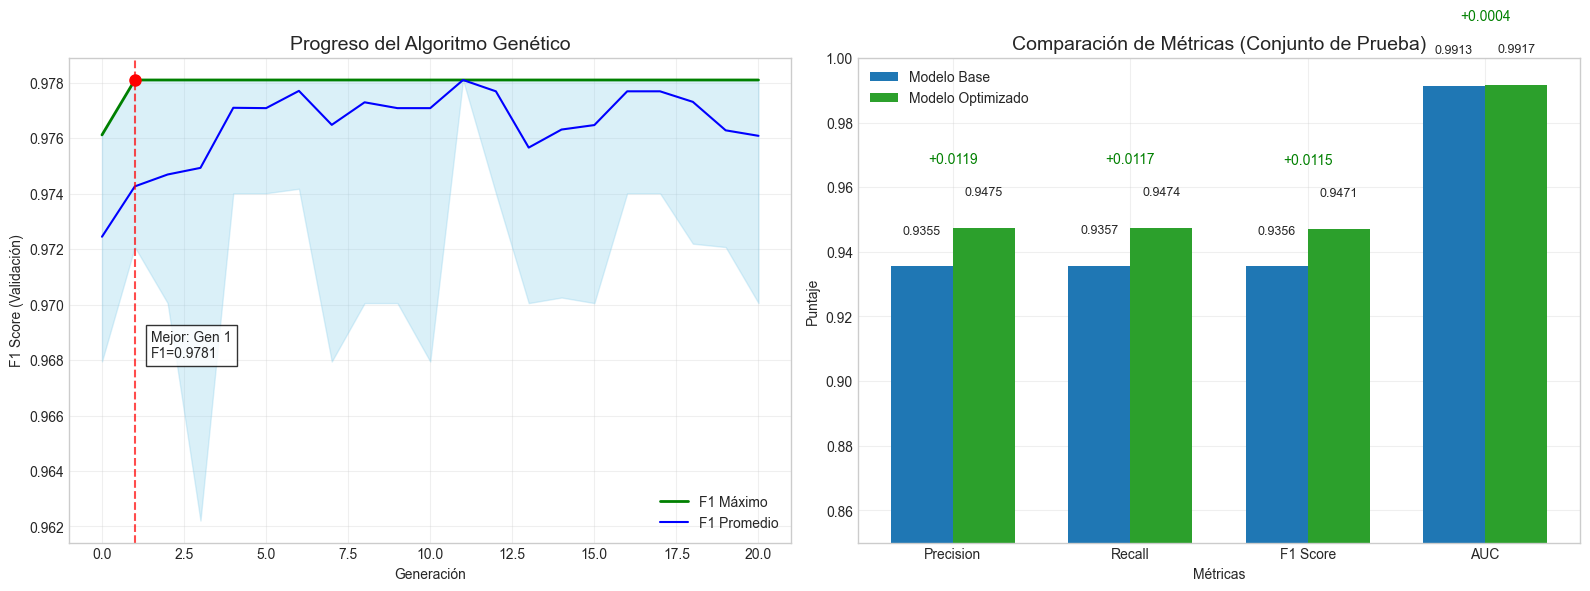

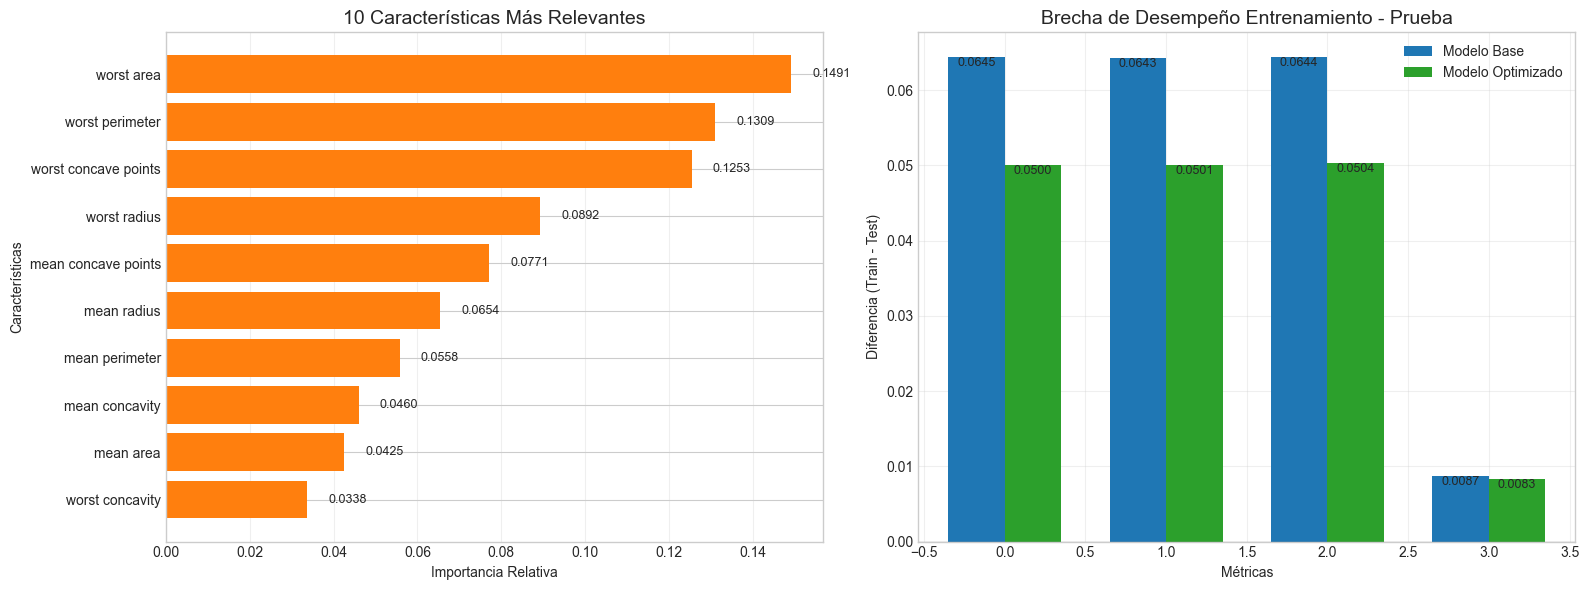

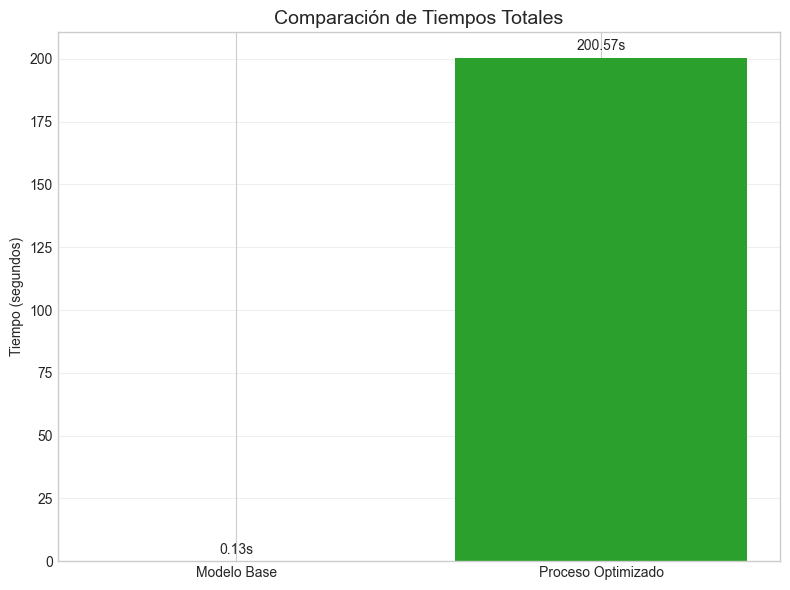

In [8]:
if __name__ == "__main__":
    main()

# 5. Conclusión reflexiva

> **Nota Importante: Los resultados aca analizados fueron obtenidos en la ejecución que quedó registrada en las salidas de celdas, esto es debido a que noté que los resultados varían entre ejecuciones, principalmente los del modelo optimizado, ya que algunas veces me mostraba aproximadamente 0.94 y otras 0.92 en F1-Score.**

La comparación entre el modelo base y el modelo optimizado mediante algoritmo genético (AG) evidencia una **mejora generalizada en el rendimiento**, validando la efectividad de este enfoque. El modelo base alcanzó un **F1 Score en test de 0.9356**, mientras que el modelo optimizado logró **0.9471**, además de mejoras en precisión, recall y AUC. Aunque las diferencias numéricas son pequeñas, en problemas críticos como el diagnóstico médico, cada decimal puede representar una decisión más precisa y confiable.

---

## Evaluación justa del rendimiento

Durante la optimización, el AG alcanzó un F1 Score de validación de **0.9781** (en la generación 1). Sin embargo, este valor corresponde a la **validación cruzada interna** durante el proceso evolutivo, **no al conjunto de test final**, y por lo tanto **no debe usarse como métrica oficial de rendimiento**.

Se reporta como resultado principal el **F1 Score sobre el conjunto de test**, con los hiperparámetros óptimos encontrados. Este valor se calcula con `average="weighted"` para considerar el desbalance de clases (64 vs. 107 muestras), reflejando de forma más precisa el rendimiento general del modelo.

---

## Justificación del uso de algoritmos genéticos

Los algoritmos genéticos (AG) demostraron ser una **alternativa sólida y eficiente** frente a métodos tradicionales como Grid Search o Random Search:

- **Grid Search**: exploración exhaustiva pero costosa.
- **Random Search**: rápida pero dependiente del azar.
- **Algoritmo Genético (AG)**: utiliza selección, cruce y mutación para buscar **combinaciones prometedoras de hiperparámetros**, convergiendo hacia mejores soluciones en menos iteraciones útiles.

En este caso, el AG identificó una combinación efectiva (`n_estimators=184, max_depth=7, min_samples_split=4`) que **mejoró el desempeño general del modelo**, como también se evidencia en el gráfico de evolución del F1 Score por generación.

---

## Consideraciones sobre eficiencia temporal

Aunque la optimización con AG toma más tiempo, este proceso:

- Se realiza **una sola vez** durante la fase de desarrollo.
- Entrega un modelo con **mejor rendimiento en test**.
- Mantiene tiempos de entrenamiento y predicción similares al modelo base (0.1332 s y 0.0155 s respectivamente).

En contextos donde el rendimiento es prioritario y el tiempo de entrenamiento no es una limitante crítica, este **costo computacional está justificado**.

---

## Análisis del GAP train-test y análisis extras

- Gap train-test:
    - Debido a que el F1-Score podía variar entre ejecuciones, se realizó un gráfico de gap difference, que muestra la diferencia entre el rendimiento del modelo en los datos de entrenamiento y los datos de prueba (test) en alguna métrica, por ejemplo F1-Score. 
    - En este caso, se puede observar que el modelo optimizado tiene un gap menor en todas sus métricas, un gap train-test menor en el modelo optimizado significa que el modelo es más robusto y generaliza mejor.
    - Porbablemente se encontro una combinación de hiperparámetros que no solo mejora el rendimiento, sino también la estabilidad del modelo frente a datos nuevos, a pesar de que el F1-Score podría ser menor que el modelo base (para probar, se puede correr nuevamente el código)

- El análisis del **Top 10 de variables más importantes** aporta transparencia al modelo.
- Las visualizaciones de evolución métrica y comparación temporal complementan el análisis, asegurando trazabilidad y claridad en el proceso.

---

## Conclusión final

El uso de algoritmos genéticos permitió:

- Mejorar el rendimiento general del modelo, además de añadirle estabilidad al modelo frente a datos nuevos.
- Optimizar hiperparámetros de forma eficiente e inteligente.
- Mantener interpretabilidad y tiempos de predicción adecuados.

En conclusión, los algoritmos genéticos **no solo mejoran la precisión del modelo**, sino que lo hacen de forma **justificable y reproducible**, siendo una herramienta potente en problemas reales donde el rendimiento sí importa.